# Generalization

As a final experiment, we will try and find whether there exist any differences between the extent to which agents of different language are able to generalize. While we expect to find that all agents are able to generalize to a certain extent, some might be better able to generalize than others. This is based on the fact that agents seem to use completely different structures within their language, as is appointed by the problem area RSA figure. If structures are similar between languages, we will likely find that agents are able to generalize to similar extent. Differences in performance on new (not seen before) samples will indicate the degree of which structure in the created languages will differ.

In [1]:
import glob
import pickle
from metrics import *
import matplotlib.pyplot as plt
from scipy import spatial
from data import one_hot


In [2]:
# functions for loading data

def load_metrics(path):
    """
        This function loads metrics
    """

    # load the data
    seed_folders = glob.glob(f"{path}/*")

    # save results
    generalize_result = {}
    train_result = {}

    # run through all seed
    for s in seed_folders:

        # get seed index
        seed = s.split("/")[-1]
        
        # make sure to ignore the rsa analysis for now
        if seed == 'rsa_analysis.pkl':
            continue

        # get all metric files
        metric_files = glob.glob(s + "/*.pkl")

        for file in metric_files:

            # load files
            m1 = pickle.load(open(file, "rb"))

            # check if file is generalize or train metric
            if file.find('generalize') == -1:
                if file.find('10000') != -1:
                    train_result[seed] = m1
            else:
                generalize_result[seed] = m1                

    return train_result, generalize_result

def on_hot_hamming(a, b):
    return spatial.distance.hamming(
        one_hot(a, n_cols=VOCAB).flatten(), one_hot(b, n_cols=VOCAB).flatten()
    )

def levenshtein_ratio_and_distance(s, t):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position
                         # [i,j] then the cost is 0
            else:
                # If we choose to calculate the ratio the cost of a substitution is 2.
                cost = 2

            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions

    # Computation of the Levenshtein Distance Ratio
    Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
    return Ratio


def get_similarity(train_data, generalize_data):

    # extract targets
    train_targets = train_data['targets']
    generalize_targets = generalize_data['targets']


    # extract messages
    train_messages = train_data['messages']
    generalize_messages = generalize_data['messages']

    # now check for the messages describing similar targets
    VOCAB = 25
    # get a target from the generalize set
    same_count = 0
    count = 0
    all_similarities = []

    for tar_i in range(len(generalize_targets)):

        target = generalize_targets[tar_i]

        for i, train_target in enumerate(train_targets):
            score = spatial.distance.hamming(target, train_target)

            # check if targets are close
            if score < 0.2:

                #print(generalize_messages[tar_i])
                #print(train_messages[i])
                #print()

                # now check for message distance
                similarity = levenshtein_ratio_and_distance(generalize_messages[tar_i], train_messages[i])

                # print(similarity)
                # print()

                all_similarities.append(similarity)
                
    return np.average(all_similarities)
   

# Choose a run

In [75]:
#path = "split_runs/90-10-split/lstm_max_len_10_vocab_25_attr_5_split"
path = "runs/lstm_max_len_10_vocab_25_attr_5_split_2"

# paths = ["runs/lstm_max_len_10_vocab_25_attr_5_split_1",
#         "runs/lstm_max_len_10_vocab_25_attr_5_split_2",
#         "runs/lstm_max_len_10_vocab_25_attr_5_split_3",
#         "runs/lstm_max_len_10_vocab_25_attr_3_split_2"]

paths = ["runs/lstm_max_len_10_vocab_25_attr_5_split_2",
        "runs/lstm_max_len_10_vocab_25_same_data_attr_5_split_2",]

train, generalize = load_metrics(path)

# Plot results

In [76]:
# plot code
def plot_results(paths, individual=False):
    
    for path in paths:
        
        train, generalize = load_metrics(path)
        fig, ax = plt.subplots(figsize=(15,8))

        index = np.arange(10)

        bar_width = 0.6
        opacity = 0.7

        all_gen_acc = []
        all_train_acc = []
        # get the accuracy
        for i, seed in enumerate(sorted(generalize.keys())):

            # get the accuracy for the seed
            gen_acc = generalize[seed]['acc']
            train_acc = train[seed]['acc']
            all_gen_acc.append(gen_acc)
            all_train_acc.append(train_acc)
            
            if individual:
                print()
                print('Training accuracy for seed ' + seed + ': ' + str(train_acc))
                print('Generalization accuracy for seed ' + seed + ': ' + str(gen_acc))

        # plot the bar
        trainBar = ax.bar(index, all_train_acc, bar_width,
                alpha=0.6,
                label='Train')
        
        genBar = ax.bar(index, all_gen_acc, bar_width,
                alpha=0.8,
                label='Generalize')
        
        for rect in trainBar:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/3., 1.01*height,
                    '%10.3f' % height,
                    ha='center', va='bottom')
            
        for rect in genBar:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/3., 0.5*height,
                    '%10.3f' % height,
                    ha='center', va='bottom', color='white')

        plt.ylabel('Accuracy')
        plt.title(path)
        plt.xlabel('seed')
        plt.xticks(index, tuple([i for i in sorted(generalize.keys())]))
        plt.legend()

        plt.show()
        
        print('Mean training accuracy: ' + str(np.mean(all_train_acc)))
        print('Mean generalization accuracy: ' + str(np.mean(all_gen_acc)))
        
    return all_acc



# Accuracy comparison (generalize vs train)

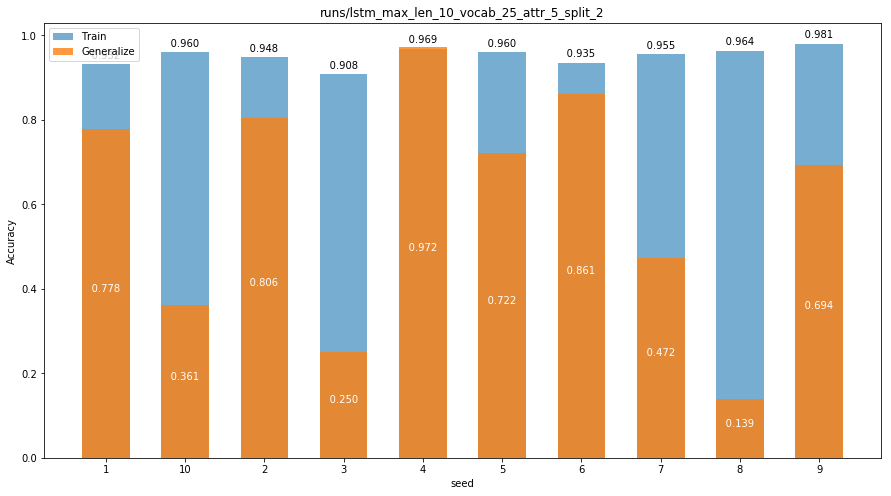

Mean training accuracy: 0.9510416669504982
Mean generalization accuracy: 0.6055555629233519


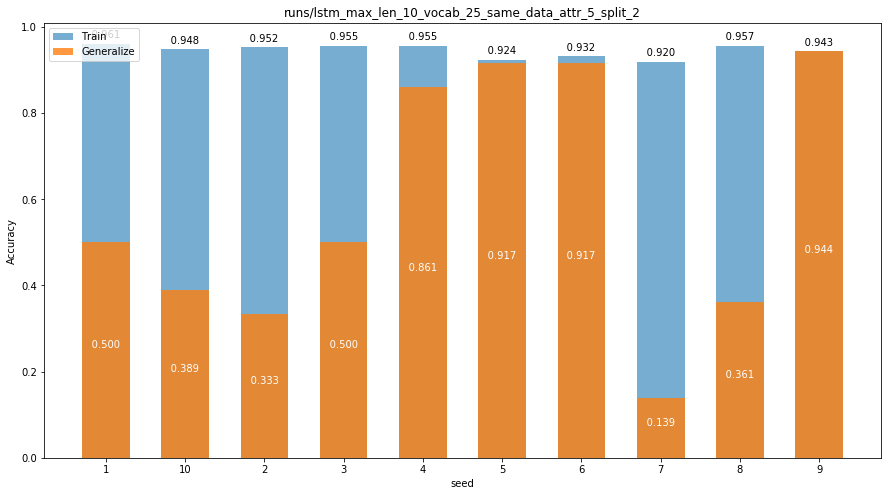

Mean training accuracy: 0.9447916678019933
Mean generalization accuracy: 0.5861111151675382


NameError: name 'all_acc' is not defined

In [77]:
all_acc = plot_results(paths)

## Show that the targets are the same across all seeds

In [82]:
for path in paths:
    train, generalize = load_metrics(path)
    
    print('-----------' + path + '-------------')
    # create set
    targets = set()
    distractors = set()
    
    t_targets = set()
    t_distractors = set()
    
    for seed in train.keys():
        
        for tar in generalize[seed]['targets']:            
            targets.add(tuple(tar))
            
        for dis in generalize[seed]['distractors']:
            distractors.add(tuple(dis))
            
        for tar in train[seed]['targets']:            
            t_targets.add(tuple(tar))
            
        for dis in train[seed]['distractors']:
            t_distractors.add(tuple(dis))
        

        print('generalize targets: ', len(targets))
        print('generalize distractors: ', len(distractors))
        print()
        print('train targets: ', len(t_targets))
        print('train distractors: ', len(t_distractors))
        print()
    print()
    

            

-----------runs/lstm_max_len_10_vocab_25_attr_5_split_2-------------
generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  205

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  215

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  71

train targets:  216
train distractors:  216

generalize targets:  27
generalize distractors:  

In [107]:
from itertools import combinations

path = "runs/lstm_max_len_10_vocab_25_same_data_attr_5_split_2"

train, generalize = load_metrics(path)

train_targets = []
train_distractors = []
gen_targets = []
gen_distractors = []

# extract all targets
for seed in train.keys():
    train_targets.append(train[seed]['targets'])
    train_distractors.append(train[seed]['distractors'])
    gen_targets.append(train[seed]['targets'])
    gen_distractors.append(train[seed]['distractors'])

    
def check_equal(samples, check):
    for t1, t2 in combinations(samples,2):
        if not np.array_equal(t1,t2):
            print('Not equal, ', check)


check_equal(train_targets, 0)

check_equal(train_distractors, 1)

check_equal(gen_targets, 2)

check_equal(gen_distractors, 3)


In [106]:
path = "runs/lstm_max_len_10_vocab_25_attr_5_split_2/pair1"

train, generalize = load_metrics(path)

print(generalize['1']['targets'])
print(generalize['2']['targets'])


[[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.

# RSA analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


runs/lstm_max_len_10_vocab_25_same_data_attr_5_split_2


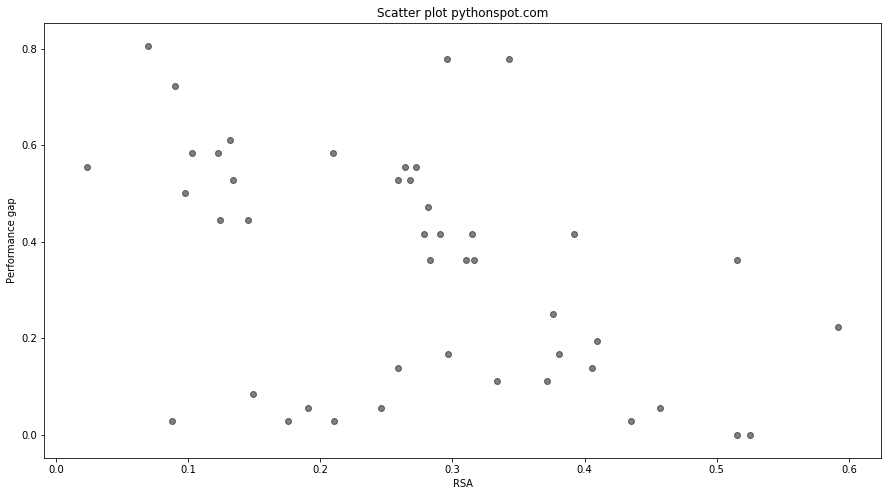

-0.4352109351429901


In [79]:
from scipy.stats import pearsonr

# open file
print(path)
file = path + '/rsa_analysis.pkl'
results = pickle.load(open(file, 'rb'))

# open accuracies
train, generalize = load_metrics(path)

rsa_array = []
perf_gap = []

for seed in results['ham_messages']:
    
    if len(seed) > 5:
        continue        
    
    # extract rsa
    rsa_array.append(results['ham_messages'][seed][10000])
        
    # split seeds
    
    # first check if there is a 10
    index = seed.find('10')
    
    if index > -1:
        # extract seeds
        s1 = seed[index:index+2]
        s2 = seed[0:index:] + seed[index + 2::]
    else:
        # split equally
        s1 = seed[0]
        s2 = seed[1]
        
    # extract performance gap
    a1 = generalize[s1]['acc']
    a2 = generalize[s2]['acc']
    
    perf_gap.append(abs(a1-a2))
    
fig, ax = plt.subplots(figsize=(15,8))
colors = (0,0,0)


# Plot
plt.scatter(rsa_array, perf_gap, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('RSA')
plt.ylabel('Performance gap')
plt.show()

r = pearsonr(rsa_array, perf_gap)[0]

print(r)



# print rsa's

## Statistical test
To find out whether the performances actually significantly differ, we check whether the distribution is normally distributed or not. The though behind this is that normally distributed data is data that does not differ much within its own distribution. In this case, we want to prove that data is actually distributed in a non-normally distributed way, since all seeds appear to have their own solution. The performances should be all over the place, and thus not normally distributed.

In [74]:
from scipy.stats import shapiro, ttest_ind

train, generalize = load_metrics(path)

all_gen_acc = []
all_train_acc = []

# get the accuracy
for i, seed in enumerate(sorted(generalize.keys())):

    # get the accuracy for the seed
    gen_acc = generalize[seed]['acc']
    train_acc = train[seed]['acc']
    all_gen_acc.append(gen_acc)
    all_train_acc.append(train_acc)
    
    

print(shapiro(all_gen_acc))


print(shapiro(all_train_acc))

print(ttest_ind(all_gen_acc, all_train_acc))

(0.9275479316711426, 0.4242120385169983)
(0.945758044719696, 0.6186644434928894)
Ttest_indResult(statistic=-3.871451135135072, pvalue=0.0011183512143417274)


## Conclusion
There exists some correlation between the performance gap and the RSA in messages, however this is a very significant correlation. We need something to compare this to.

# Manual RSA analysis

In [10]:
def get_same_count(generalize, train):
    # now check for the messages describing similar targets
    VOCAB = 25
    # get a target from the generalize set
    same_count = 0
    count = 0
    #seed = '4'
    for tar_i in range(len(generalize['targets'])):

        target = generalize['targets'][tar_i]

        #print('Generalize message: ', generalize['messages'][tar_i])

        # extract targets
        train_targets = train['targets']
        generalize_targets = generalize['targets']

        # extract messages
        train_messages = train['messages']
        generalize_messages = generalize['messages']


        for i, train_target in enumerate(train_targets):
            score = spatial.distance.hamming(target, train_target)

            # check if targets are close
            if score < 0.2:
                
                # keep track of the amount of similar targets               
                count += 1
                
                # check whether the messages are identical for these similar targets
                if tuple(train_messages[i]) == tuple(generalize_messages[tar_i]):
                    same_count += 1
                    
    return same_count, count


# Nr of identical messages
But how many of the targets actually produce identical messages?

In [189]:
for seed in sorted(train.keys()):
    #print('For seed ' + str(seed) + ', we find the following amount of identical messages:')
    same_count, count = get_same_count(generalize[seed], train[seed])
    print(same_count, '/', count)

#print(same_count, '/', count)  

30 / 66
20 / 66
29 / 66
0 / 66
11 / 66
17 / 66
16 / 66
6 / 66
4 / 66
20 / 66


How identical are the messages? Compared to the targets?

In [190]:
from itertools import combinations

generalize_messages = generalize[seed]['messages']

similarities = []
for (message1, message2) in combinations(generalize_messages, 2):
    similarity = levenshtein_ratio_and_distance(message1,message2)
    similarities.append(similarity)

print(np.average(similarities))        

distances = []
for (target1, target2) in combinations(generalize_targets, 2):
    distance = spatial.distance.hamming(target1, target2)
    distances.append(distance)
    
print(np.average(distances))

0.43030303030303024
0.2769230769230769


Do the others resemble any similarities? Let's try and show that by checking at the distances between the messages

In [191]:
# go through all seeds
print()
for seed in sorted(train.keys()):
    
    sim = get_similarity(train[seed], generalize[seed])
    print('Seed ' + str(seed) + ': \t' + str(sim))


Seed 1: 	0.7107438016528925
Seed 10: 	0.5840220385674931
Seed 2: 	0.7258953168044077
Seed 3: 	0.5661157024793387
Seed 4: 	0.696969696969697
Seed 5: 	0.637741046831956
Seed 6: 	0.6239669421487603
Seed 7: 	0.5812672176308542
Seed 8: 	0.5826446280991735
Seed 9: 	0.7672176308539944


### Note that there exist pretty big differences between the train and generalize messages per initialization

# Conclusion

So far we have a couple of reasons to believe that agents actually hash new objects that they see.

First of all, if we use just a small proportion of the data for the generalization, we find that a lot of the messages (1/5) are the exact same for samples that they have not seen before.

Second, if we however use a large proportion of the data for generalization, we find that messages that are used for these newly seen objects are extremely similar. Which, they should not be.

The more data we use for generalization, the more similar the messages. This is in favour of the hash hypothesis. They have never seen this new target so they do not at all match it with what they currently know, instead they just try something new.

### Main finding: the more targets are unknown to the model, the more similar the messages that describe these targets are.

# What's next

Maybe check message similarity for the same targets, this will remove any data biases that might cause this effect.